# HappyDB
#### A Corpus of 100,000 Crowdsourced Happy Moments

## by Seif El-Eslam Hegazy

## - Preliminary Wrangling:

> [HappyDB](https://www.kaggle.com/ritresearch/happydb) is a corpus of more than 100,000 happy moments crowd-sourced via Amazon’s Mechanical Turk.

> Each worker is given the following task:
What made you happy today? Reflect on the past 24 hours, and recall three actual events that happened to you that made you happy.

> Dataset has 2 csv files:
- cleaned_hm.csv, the cleaned-up corpus of 100,000 crowd-sourced happy moments. The raw happy moments are retained for reference, and the author of each happy moment is represented by the his/her worker ID.
- demographic.csv includes worker id, age, country, gender, marital status, and status of parenthood.

In [189]:
# import all packages and set plots to be embedded inline
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import itertools
import collections

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## - Gathering and assessing data:

In [167]:
df1 = pd.read_csv('cleaned_hm.csv')
df2 = pd.read_csv('demographic.csv')

In [168]:
print('total number of happy moments: %d' % df1.shape[0])
print('total number of authors: %d' % df2.shape[0])

total number of happy moments: 100535
total number of authors: 10844


In [169]:
df1.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection


In [170]:
df2.head()

,wid,age,country,gender,marital,parenthood
0,1,37.0,USA,m,married,y
1,2,29.0,IND,m,married,y
2,3,25,IND,m,single,n
3,4,32,USA,m,married,y
4,5,29,USA,m,married,y


In [171]:
happy_df = pd.merge(df2, df1, left_on='wid', right_on='wid')

In [172]:
happy_df.shape

(100535, 14)

In [173]:
happy_df.columns

Index(['wid', 'age', 'country', 'gender', 'marital', 'parenthood', 'hmid',
       'reflection_period', 'original_hm', 'cleaned_hm', 'modified',
       'num_sentence', 'ground_truth_category', 'predicted_category'],
      dtype='object')

In [174]:
happy_df.head()

,wid,age,country,gender,marital,parenthood,hmid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,1,37.0,USA,m,married,y,27854,24h,My wife and i are celebrating our ten year ann...,My wife and i are celebrating our ten year ann...,True,1,NaN,affection
1,1,37.0,USA,m,married,y,28054,24h,My mother called out of the blue to tell me ho...,My mother called out of the blue to tell me ho...,True,1,affection,affection
2,1,37.0,USA,m,married,y,28254,24h,Today i took the day off from my part time job...,Today i took the day off from my part time job...,True,1,NaN,affection
3,1,37.0,USA,m,married,y,28489,24h,I just got a $21 bonus on a mturk task!,I just got a $21 bonus on a mturk task!,True,1,NaN,achievement
4,1,37.0,USA,m,married,y,28991,24h,My wife cooked me a surprise dinner to take to...,My wife cooked me a surprise dinner to take to...,True,1,NaN,affection


In [175]:
happy_df.drop(['hmid', 'original_hm', 'modified', 'num_sentence', 'ground_truth_category'], axis=1, inplace=True)

In [176]:
happy_df.shape

(100535, 9)

In [177]:
happy_df.columns

Index(['wid', 'age', 'country', 'gender', 'marital', 'parenthood',
       'reflection_period', 'cleaned_hm', 'predicted_category'],
      dtype='object')

In [178]:
happy_df.head()

,wid,age,country,gender,marital,parenthood,reflection_period,cleaned_hm,predicted_category
0,1,37.0,USA,m,married,y,24h,My wife and i are celebrating our ten year ann...,affection
1,1,37.0,USA,m,married,y,24h,My mother called out of the blue to tell me ho...,affection
2,1,37.0,USA,m,married,y,24h,Today i took the day off from my part time job...,affection
3,1,37.0,USA,m,married,y,24h,I just got a $21 bonus on a mturk task!,achievement
4,1,37.0,USA,m,married,y,24h,My wife cooked me a surprise dinner to take to...,affection


## - Cleaning data:

In [179]:
# columns info
happy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100535 entries, 0 to 100534
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   wid                 100535 non-null  int64 
 1   age                 100442 non-null  object
 2   country             100332 non-null  object
 3   gender              100456 non-null  object
 4   marital             100378 non-null  object
 5   parenthood          100457 non-null  object
 6   reflection_period   100535 non-null  object
 7   cleaned_hm          100535 non-null  object
 8   predicted_category  100535 non-null  object
dtypes: int64(1), object(8)
memory usage: 7.7+ MB


In [180]:
# count null values
happy_df.isnull().sum()

wid                     0
age                    93
country               203
gender                 79
marital               157
parenthood             78
reflection_period       0
cleaned_hm              0
predicted_category      0
dtype: int64

- since main variables are categorical, and dataset has more than 100,000 observations. So dropping null values will be fastest and easiest way to handle null values.

In [181]:
happy_df.dropna(inplace=True)

In [182]:
happy_df.shape

(100082, 9)

In [183]:
# check columns types
for col in happy_df.columns:
    print(col, type(happy_df[col].iloc[0]))

wid <class 'numpy.int64'>
age <class 'str'>
country <class 'str'>
gender <class 'str'>
marital <class 'str'>
parenthood <class 'str'>
reflection_period <class 'str'>
cleaned_hm <class 'str'>
predicted_category <class 'str'>


In [184]:
# convert age to int
happy_df['age'] = pd.to_numeric(happy_df['age'], errors='coerce')

In [185]:
happy_df['age'].describe()

count    100034.000000
mean         32.512596
std          11.052510
min           2.000000
25%          26.000000
50%          30.000000
75%          36.000000
max         233.000000
Name: age, dtype: float64

> It seems that age has some outliers and incurrect data. Age > 100 and age < 10 years will be ignored.

In [186]:
happy_df = happy_df[(happy_df['age'] <= 100) & (happy_df['age'] >= 10)] 

In [187]:
happy_df.shape

(99878, 9)

In [188]:
happy_df['age'].describe()

count    99878.000000
mean        32.421214
std          9.877295
min         17.000000
25%         26.000000
50%         30.000000
75%         36.000000
max         98.000000
Name: age, dtype: float64

- Split each momoent into words and remove any special characters and stop words

In [190]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/Seif/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [191]:
stop_words = set(stopwords.words('english'))

In [192]:
def split_into_words(text):
    clean_text = re.sub('[^A-Za-z0-9 ]+', '', text)
    words = clean_text.lower().split()
    return [word for word in words if not word in stop_words]

In [193]:
happy_df['hm_words'] = happy_df['cleaned_hm'].apply(split_into_words)

In [194]:
happy_df['hm_words']

0         [wife, celebrating, ten, year, anniversary, to...
1                       [mother, called, blue, tell, proud]
2         [today, took, day, part, time, job, go, brunch...
3                             [got, 21, bonus, mturk, task]
4              [wife, cooked, surprise, dinner, take, work]
                                ...                        
100530    [older, dog, made, surgery, well, spite, mildl...
100531    [daughter, spontaneously, hugs, visit, lately,...
100532    [boyfriend, got, thoughtful, gifts, birthday, ...
100533               [cap, gown, graduation, arrived, mail]
100534    [went, pick, son, split, custody, ran, incredi...
Name: hm_words, Length: 99878, dtype: object

In [195]:
happy_df.drop(['cleaned_hm'], axis=1, inplace=True)

In [196]:
happy_df.rename(columns={'predicted_category':'category'}, inplace=True)

In [197]:
happy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99878 entries, 0 to 100534
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wid                99878 non-null  int64  
 1   age                99878 non-null  float64
 2   country            99878 non-null  object 
 3   gender             99878 non-null  object 
 4   marital            99878 non-null  object 
 5   parenthood         99878 non-null  object 
 6   reflection_period  99878 non-null  object 
 7   category           99878 non-null  object 
 8   hm_words           99878 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 7.6+ MB


In [198]:
happy_df.to_csv('cleaned_happy_dataset.csv', sep=',', encoding='utf-8')

### What is the structure of your dataset?

> Dataset contains 100082 observations with 8 features.

- continuous quantitative data :
  - age
- nominal categorical data:
  - country
  - gender
  - martial
  - parenthood
  - category
  - reflection_period
- string list:
  - hm_words

### What is/are the main feature(s) of interest in your dataset?

> Figuring out what features affect people's happiness. What makes people happy.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Actually all dataset features have an impact on happiness. Age, country, gender, martial and parenthood are considered main contributors of people happiness. Also category of happy moment indicates the common types of happiness. Reflection period indicates long/short term happy moments. How people described their happy moments also gives insight about happiness reasons.

## Univariate Exploration

### Age distribution:

In [199]:
happy_df['age'].describe()

count    99878.000000
mean        32.421214
std          9.877295
min         17.000000
25%         26.000000
50%         30.000000
75%         36.000000
max         98.000000
Name: age, dtype: float64

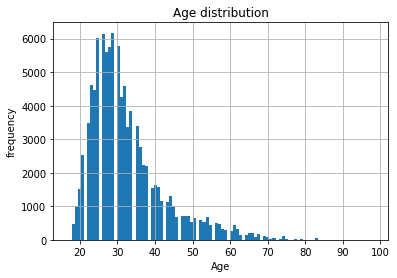

In [200]:
happy_df['age'].hist(bins=100);
plt.xlabel('Age')
plt.ylabel('frequency')
plt.title('Age distribution');

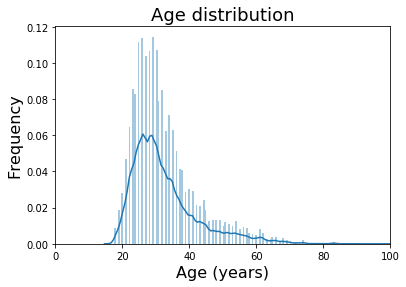

In [201]:
sb.distplot(happy_df['age'], bins=150)
plt.xlim(0, 100)
plt.title('Age distribution', fontsize=18)
plt.xlabel('Age (years)', fontsize=16)
plt.ylabel('Frequency', fontsize=16);

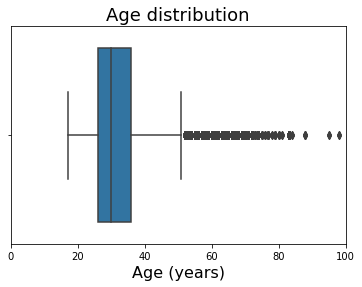

In [202]:
sb.boxplot(happy_df['age']);
plt.xlim(0, 100)
plt.title('Age distribution', fontsize=18)
plt.xlabel('Age (years)', fontsize=16);

> - The mean age of participants = 32.5 years
> -  50% of age of participants ranges from 26 - 36 years 
> - so major participants are young people

### Country exploration:

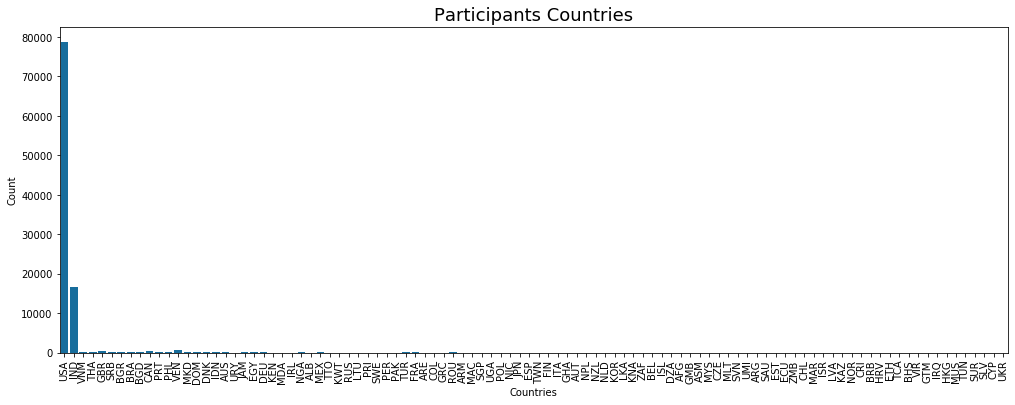

In [203]:
plt.rcParams['figure.figsize'] = 17, 6
base_color = sb.color_palette('colorblind')[0]
sb.countplot(data=happy_df, x='country', color=base_color);
plt.xticks(rotation=90);
plt.title('Participants Countries', fontsize=18)
plt.xlabel('Countries');
plt.ylabel('Count');

In [204]:
happy_df['country'].value_counts()

USA    78728
IND    16633
VEN      588
CAN      549
GBR      358
       ...  
SUR        3
SAU        3
ISR        3
HKG        3
LVA        3
Name: country, Length: 100, dtype: int64

To get good insights about country happiness contribution, observations of countries that has count less than 1000 will be ignored

In [205]:
value_counts = happy_df['country'].value_counts()
to_remove = value_counts[value_counts < 1000].index
happy_df2 = happy_df[~happy_df.country.isin(to_remove)]

In [206]:
happy_df2.shape

(95361, 9)

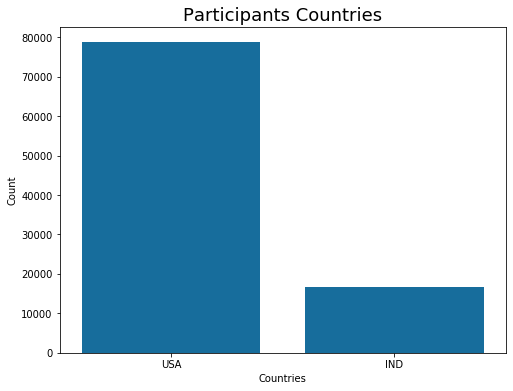

In [207]:
plt.rcParams['figure.figsize'] = 8, 6
base_color = sb.color_palette('colorblind')[0]
sb.countplot(data=happy_df2, x='country', color=base_color);
# plt.xticks(rotation=90);
plt.title('Participants Countries', fontsize=18)
plt.xlabel('Countries');
plt.ylabel('Count');

> Major participants from USA, then India.

### Gender exploration:

In [208]:
happy_df2['gender'].value_counts()

m    54074
f    40635
o      652
Name: gender, dtype: int64

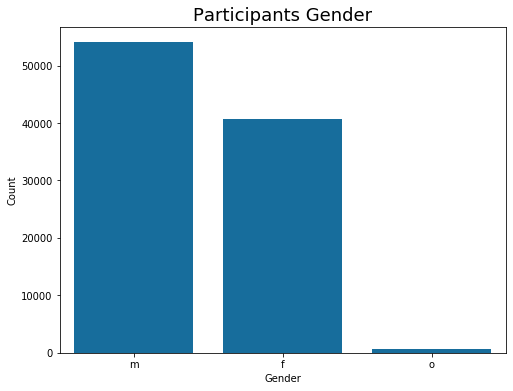

In [209]:
plt.rcParams['figure.figsize'] = 8, 6
base_color = sb.color_palette('colorblind')[0]
sb.countplot(data=happy_df2, x='gender', color=base_color);
# plt.xticks(rotation=90);
plt.title('Participants Gender', fontsize=18)
plt.xlabel('Gender');
plt.ylabel('Count');

> Major participants are males, then females

### Marital status exploration:

In [210]:
happy_df2['marital'].value_counts()

single       50935
married      39698
divorced      3662
separated      616
widowed        450
Name: marital, dtype: int64

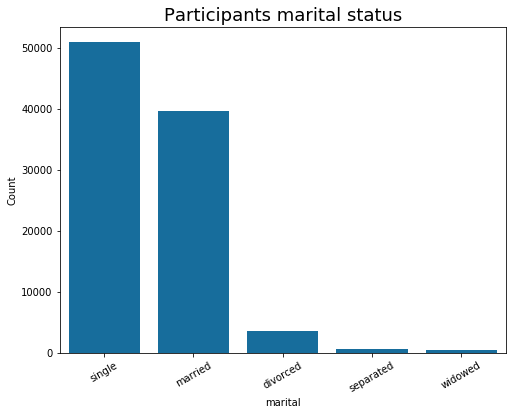

In [211]:
plt.rcParams['figure.figsize'] = 8, 6
base_color = sb.color_palette('colorblind')[0]
sb.countplot(data=happy_df2, x='marital', color=base_color, order = happy_df2['marital'].value_counts().index);
plt.xticks(rotation=30);
plt.title('Participants marital status', fontsize=18)
plt.xlabel('marital');
plt.ylabel('Count');

> Major participants are single, then married people. Minor participants are divorced, separated and widowed.

### Parenthood exploration:

In [212]:
happy_df2['parenthood'].value_counts()

n    57415
y    37946
Name: parenthood, dtype: int64

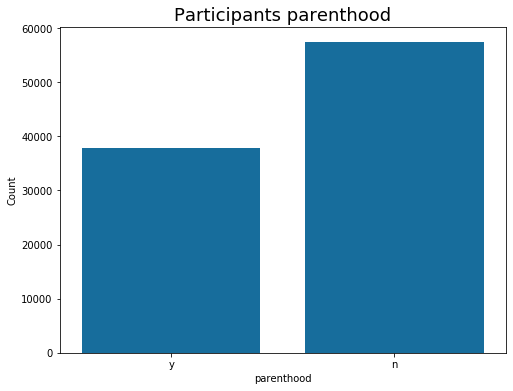

In [213]:
plt.rcParams['figure.figsize'] = 8, 6
base_color = sb.color_palette('colorblind')[0]
sb.countplot(data=happy_df2, x='parenthood', color=base_color);
# plt.xticks(rotation=90);
plt.title('Participants parenthood', fontsize=18)
plt.xlabel('parenthood');
plt.ylabel('Count');

> participants with no parenthood had more happy moments

### Reflection period exploration:

In [214]:
happy_df2['reflection_period'].value_counts()

3m     48132
24h    47229
Name: reflection_period, dtype: int64

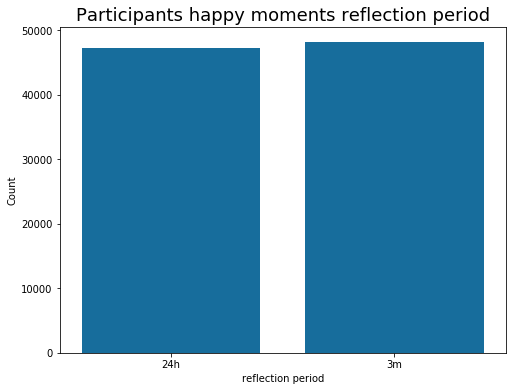

In [215]:
plt.rcParams['figure.figsize'] = 8, 6
base_color = sb.color_palette('colorblind')[0]
sb.countplot(data=happy_df2, x='reflection_period', color=base_color);
# plt.xticks(rotation=90);
plt.title('Participants happy moments reflection period', fontsize=18)
plt.xlabel('reflection period');
plt.ylabel('Count');

> The dataset is composed of happy moments from two reflection_period, 24 hours and 3 months. Both options have almost the same occurrence.

### Happiness category exploration:

In [216]:
happy_df2['category'].value_counts()

affection           32558
achievement         32104
enjoy_the_moment    10534
bonding             10168
leisure              7091
nature               1756
exercise             1150
Name: category, dtype: int64

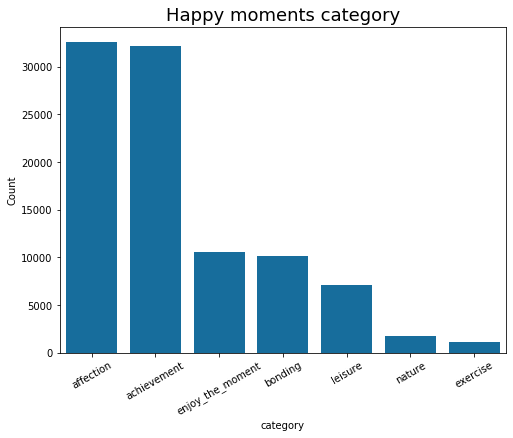

In [217]:
plt.rcParams['figure.figsize'] = 8, 6
base_color = sb.color_palette('colorblind')[0]
sb.countplot(data=happy_df2, x='category', color=base_color, order = happy_df2['category'].value_counts().index);
plt.xticks(rotation=30);
plt.title('Happy moments category', fontsize=18)
plt.xlabel('category');
plt.ylabel('Count');

> Happy moments of affection & achievement are major types. Minor types are enjoy_the_moment, bonding, leisure, nature and exercise.

### How people described their happy moments:

In [218]:
common_words = []
for words in happy_df['hm_words']:
    common_words.extend(words)

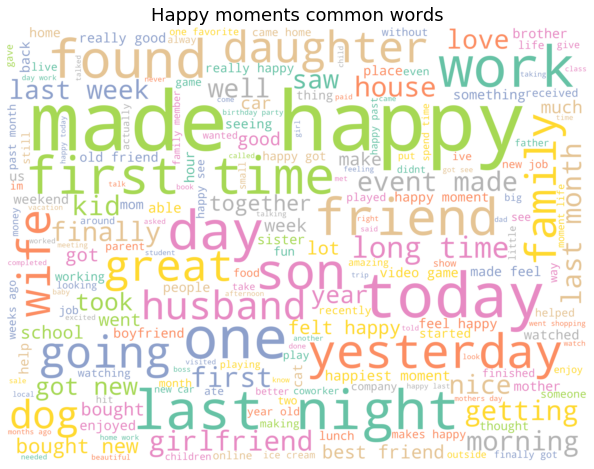

In [219]:
common_words_str = ','.join(common_words)
wordcloud = WordCloud(background_color="white", height=2700, width=3600).generate(common_words_str)
plt.figure( figsize=(14,8) )
plt.title('Happy moments common words', fontsize=18)
plt.imshow(wordcloud.recolor(colormap=plt.get_cmap('Set2')), interpolation='bilinear')
plt.axis("off");

It seems that some words appear more frequently, such as "friend", "family" and "daughter".
There are also noise words that are not very informative, such as "happy", "yesterday" and "today".
Let's clean the word cloud by removing these noise.

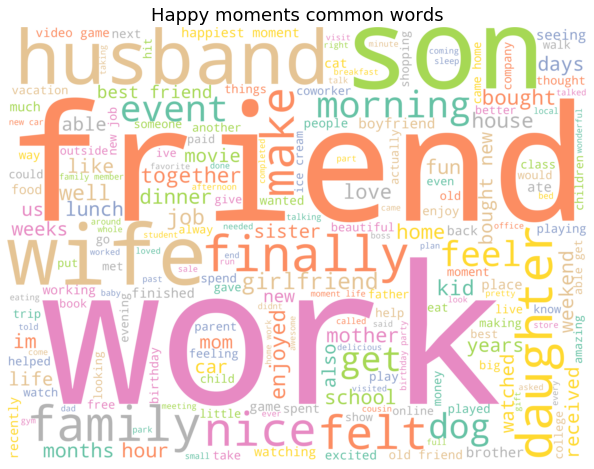

In [220]:
ignore_words = ['happy', 'day', 'got', 'went', 'today', 'made', 'one', 'two', 'time', 'last', 
                'first', 'going', 'getting', 'took', 'found', 'lot', 'really', 'saw', 'see', 
                'month', 'week', 'day', 'yesterday', 'year', 'ago', 'now', 'still', 'since',
                'something', 'great', 'good', 'long', 'thing', 'toi', 'without', 'yesteri', 
                '2s', 'toand', 'ing', 'night', 'never', 'started']
wordcloud = WordCloud(background_color="white", stopwords=set(ignore_words), height=2700, width=3600).generate(common_words_str)
plt.figure( figsize=(14,8) )
plt.title('Happy moments common words', fontsize=18)
plt.imshow(wordcloud.recolor(colormap=plt.get_cmap('Set2')), interpolation='bilinear')
plt.axis("off");

> Most of happy moments related to: **"work", "friendship", "family", "meals", "emotions", "pets", "gathering", "buying", "achievements"**

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> It is found that most of happy moments are about **affection & achievement**. To find the most common words that people used to describe their happy moments, moment describtion text is splitted, then remove any stop words. Finally all words are feed into wordCloud to see the most common words.

> Most of happy moments related to: 
  - "work"
  - "friendship"
  - "family"
  - "food"
  - "emotions"
  - "pets"
  - "gathering"
  - "buying"
  - "achievements"

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> - Age is slightly skewed to the right, and majoir of participants have age of 26-36 years old.
> - Observations of countries that has count less than 1000 will be ignored, to get good insights about country happiness contribution.
> - Major participants are single, then married people.
> - Major participants are males, then females.

## Bivariate Exploration

### Common types of happy moments VS age:

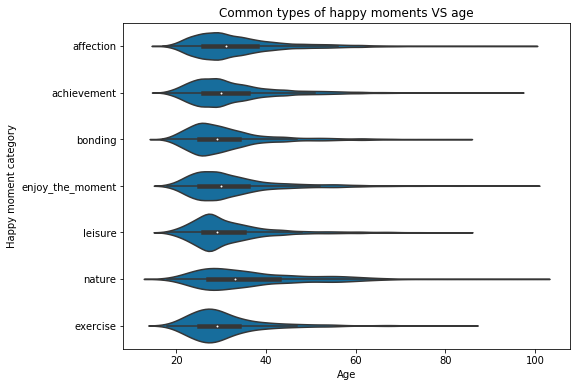

In [227]:
sb.violinplot(data=happy_df2, x='age', y='category', color=base_color);
# plt.xticks(rotation=30);
plt.title('Common types of happy moments VS age');
plt.xlabel('Age');
plt.ylabel('Happy moment category');

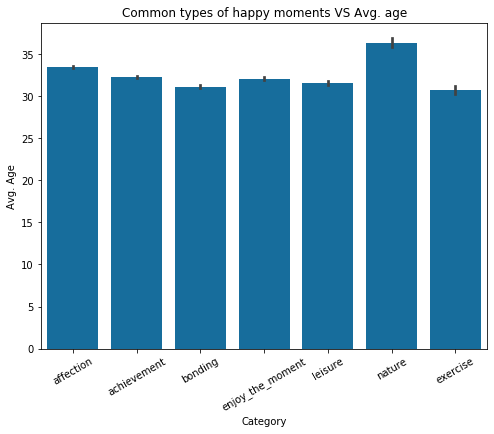

In [225]:
sb.barplot(data=happy_df2, x='category', y='age', color=base_color);
plt.xticks(rotation=30);
plt.title('Common types of happy moments VS Avg. age');
plt.xlabel('Category');
plt.ylabel('Avg. Age');

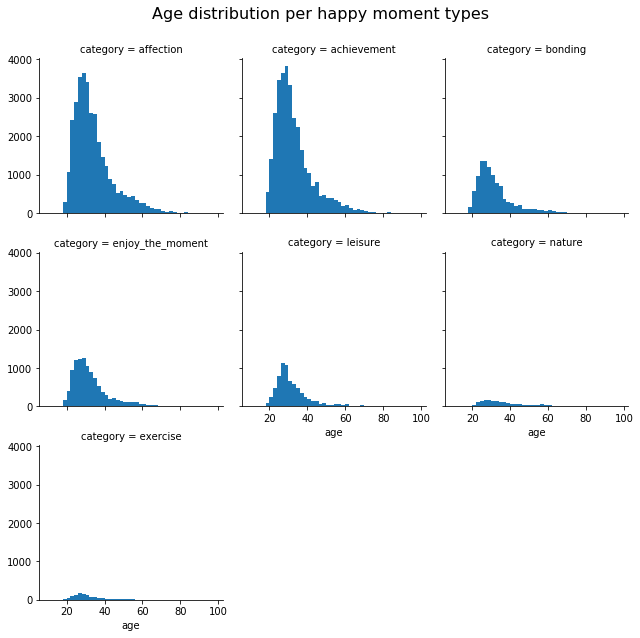

In [271]:
bin_edges = np.arange(10, happy_df2['age'].max()+1, 2)
g = sb.FacetGrid(data = happy_df2, col = 'category',col_wrap = 3, size = 3, margin_titles=True)
g.map(plt.hist, "age", bins = bin_edges);
plt.subplots_adjust(top=0.9);
# plt.subplots_adjust(hspace=0.5, wspace=0.4)
g.fig.suptitle('Age distribution per happy moment types', fontsize=16);

> - Age distributions of affection & achievement happy moments are narrow and big.
> - Lowest age distributions are for nature & exercise moments.
> - So main happy moments are affection & achievement.

### Common types of happy moments VS gender:

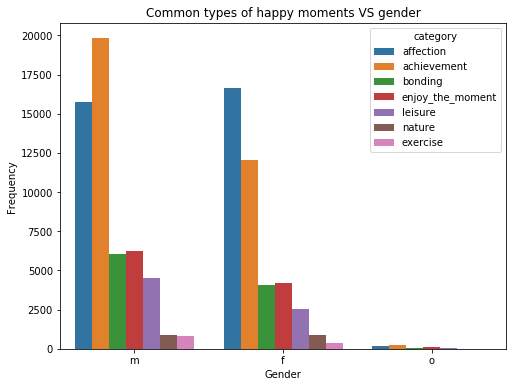

In [275]:
sb.countplot(data = happy_df2, x = 'gender', hue = 'category')
# plt.xticks(rotation=30);
plt.title('Common types of happy moments VS gender');
plt.xlabel('Gender');
plt.ylabel('Frequency');

> - Males have more achievement happy moments than females significantly.
> - Females have higher affection happy moments than males.

### Common types of happy moments VS marital status:

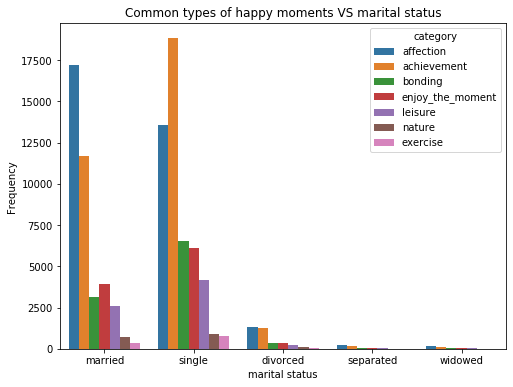

In [276]:
sb.countplot(data = happy_df2, x = 'marital', hue = 'category')
# plt.xticks(rotation=30);
plt.title('Common types of happy moments VS marital status');
plt.xlabel('marital status');
plt.ylabel('Frequency');

> - Married people have affection happy moments than achievement ones significantly.
> - Single people have achievement happy moments than affection ones significantly.
> - Single people have bonding, enjoy_the_moment and leisure moments than married people.

### Common types of happy moments VS parenthood:

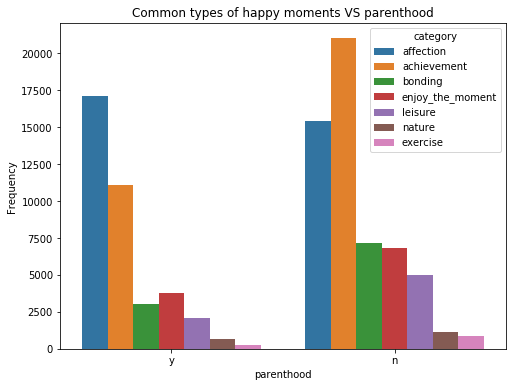

In [277]:
sb.countplot(data = happy_df2, x = 'parenthood', hue = 'category')
# plt.xticks(rotation=30);
plt.title('Common types of happy moments VS parenthood');
plt.xlabel('parenthood');
plt.ylabel('Frequency');

> - People with parenthood have more affection happy moments than people with no parenthood.
> - People with no parenthood have more achievement happy moments than people with parenthood significantly.
> - People with no parenthood have more bonding, enjoy_the_moment and leisure than than people with parenthood.

### Reflection period of happy moments types:

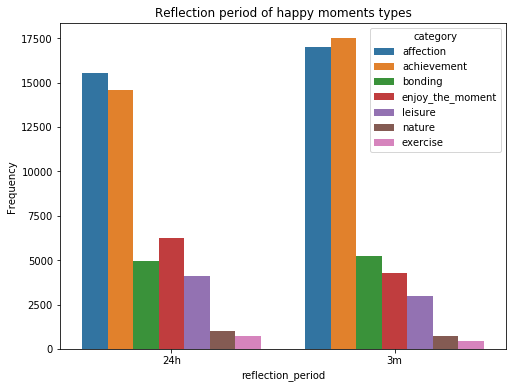

In [278]:
sb.countplot(data = happy_df2, x = 'reflection_period', hue = 'category')
# plt.xticks(rotation=30);
plt.title('Reflection period of happy moments types');
plt.xlabel('reflection_period');
plt.ylabel('Frequency');

> This graph needs another factor such as marital or parenthood to know on which base happy moments have higher reflection period


### Common types of happy moments VS country:

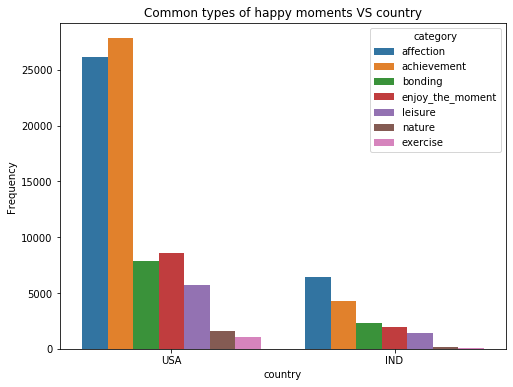

In [282]:
sb.countplot(data = happy_df2, x = 'country', hue = 'category')
# plt.xticks(rotation=30);
plt.title('Common types of happy moments VS country');
plt.xlabel('country');
plt.ylabel('Frequency');

> - However USA observations are higher than Indian ones, the pattern of India happy moments differ than USA ones.
> - USA people have affection & achievement happy moments than other types significantly than India people.  

### What people says:

In [286]:
def get_common_words(column, value):
    common_words = []
    for words in happy_df2[happy_df2[column] == value]['hm_words']:
        common_words.extend(words)
    return ','.join(common_words)

#### - Males Vs Females:

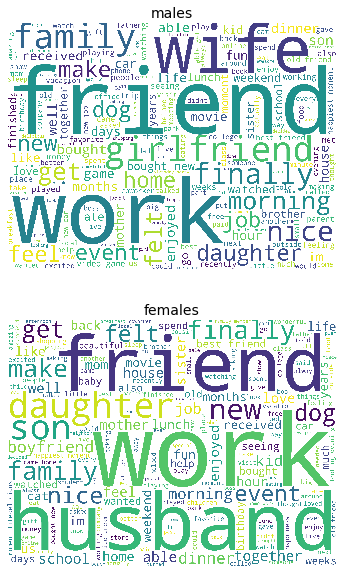

In [294]:
fig = plt.figure(figsize=(10,10))
for i, v in enumerate([('m', 'males'), ('f', 'females')]):
    common_words = get_common_words('gender', v[0])
    ax = fig.add_subplot(2,1,i+1)
    ax.set_title(v[1], fontsize=14)
    wordcloud = WordCloud(background_color="white", stopwords=set(ignore_words), height=2700, width=3600).generate(common_words)

    ax.imshow(wordcloud)
    ax.axis('off')

> There is no much difference in moments words for males and females.

#### - Single Vs Married:

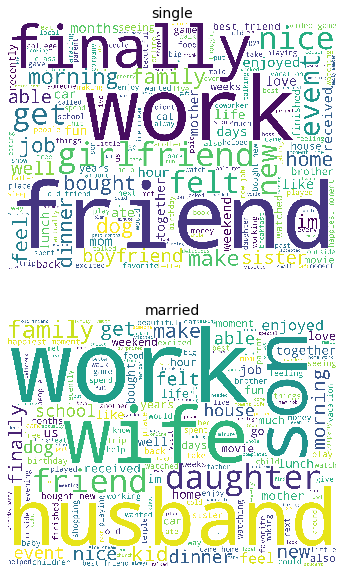

In [295]:
fig = plt.figure(figsize=(10,10))
for i, v in enumerate([('single', 'single'), ('married', 'married')]):
    common_words = get_common_words('marital', v[0])
    ax = fig.add_subplot(2,1,i+1)
    ax.set_title(v[1], fontsize=14)
    wordcloud = WordCloud(background_color="white", stopwords=set(ignore_words), height=2700, width=3600).generate(common_words)

    ax.imshow(wordcloud)
    ax.axis('off')

> - single people said more: "work", "friend", "finally", "bought"
> - Married people said more: "work", "husband", "wife", "son", "daughter"

#### - USA Vs India:

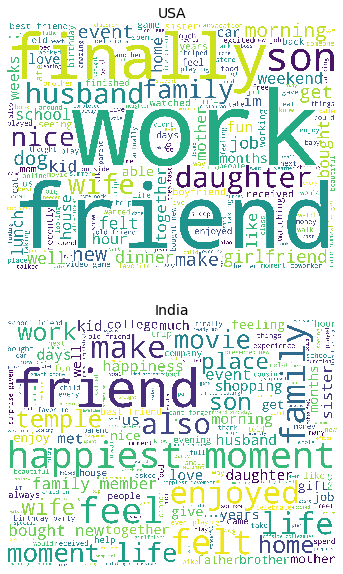

In [296]:
fig = plt.figure(figsize=(10,10))
for i, v in enumerate([('USA', 'USA'), ('IND', 'India')]):
    common_words = get_common_words('country', v[0])
    ax = fig.add_subplot(2,1,i+1)
    ax.set_title(v[1], fontsize=14)
    wordcloud = WordCloud(background_color="white", stopwords=set(ignore_words), height=2700, width=3600).generate(common_words)

    ax.imshow(wordcloud)
    ax.axis('off')

> - There is a significant difference in moments words of people of USA vs India.
> - USA people happy moments about: "Work", "friend", "finally", "family"
> - Achievement words in Indian people moments are less common. They fouced on affection moments words like: "friend", "happiest", "moment", "feel", "family"

### Gender Vs Country:

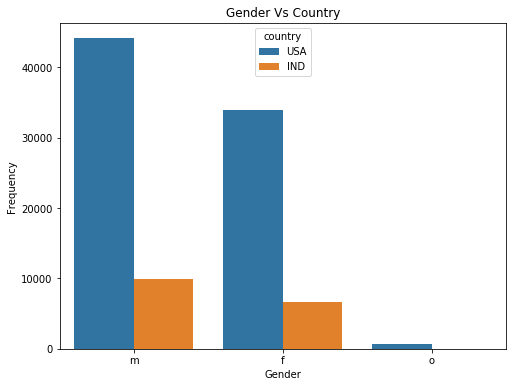

In [297]:
sb.countplot(data = happy_df2, x = 'gender', hue = 'country')
# plt.xticks(rotation=30);
plt.title('Gender Vs Country');
plt.xlabel('Gender');
plt.ylabel('Frequency');

### Marital status Vs Country:

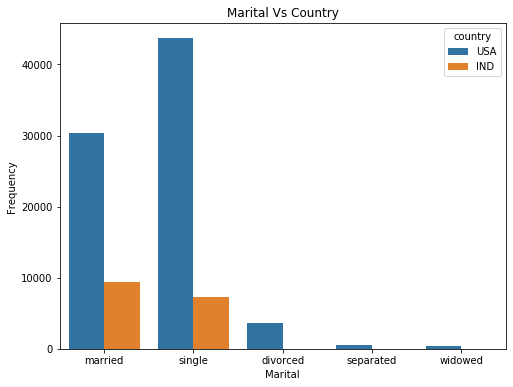

In [299]:
sb.countplot(data = happy_df2, x = 'marital', hue = 'country')
# plt.xticks(rotation=30);
plt.title('Marital Vs Country');
plt.xlabel('Marital');
plt.ylabel('Frequency');

### Parenthood Vs Country:

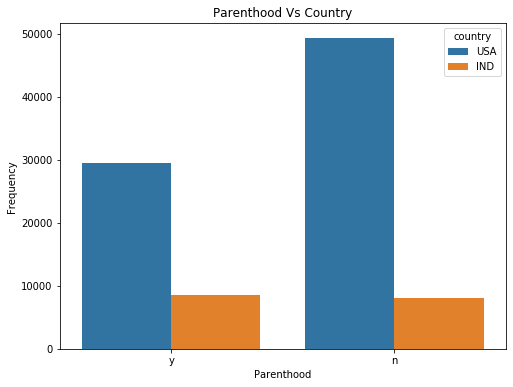

In [300]:
sb.countplot(data = happy_df2, x = 'parenthood', hue = 'country')
# plt.xticks(rotation=30);
plt.title('Parenthood Vs Country');
plt.xlabel('Parenthood');
plt.ylabel('Frequency');

> - Across all Indian observations, married people are greater than single ones. About 50% of Indian observations have parenthood.
> - Across All USA observations, single people are greater than married ones. About 60% of USA observations don't have parethood.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Types of happy moments vary with:
    - Gender: As males have more achievement happy moments than females.
    - Marital: As single people have more achievement happy moments than married ones.
    - Country: Indian people have more affection happy moments, and less than achievement comparing to American people.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Country Vs marital has an interesting relationship. Across all Indian observations, married people are greater than single ones. About 50% of Indian observations have parenthood. Across All USA observations, single people are greater than married ones. About 60% of USA observations don't have parethood.

## Multivariate Exploration

### Age Vs Country Vs Moments types:

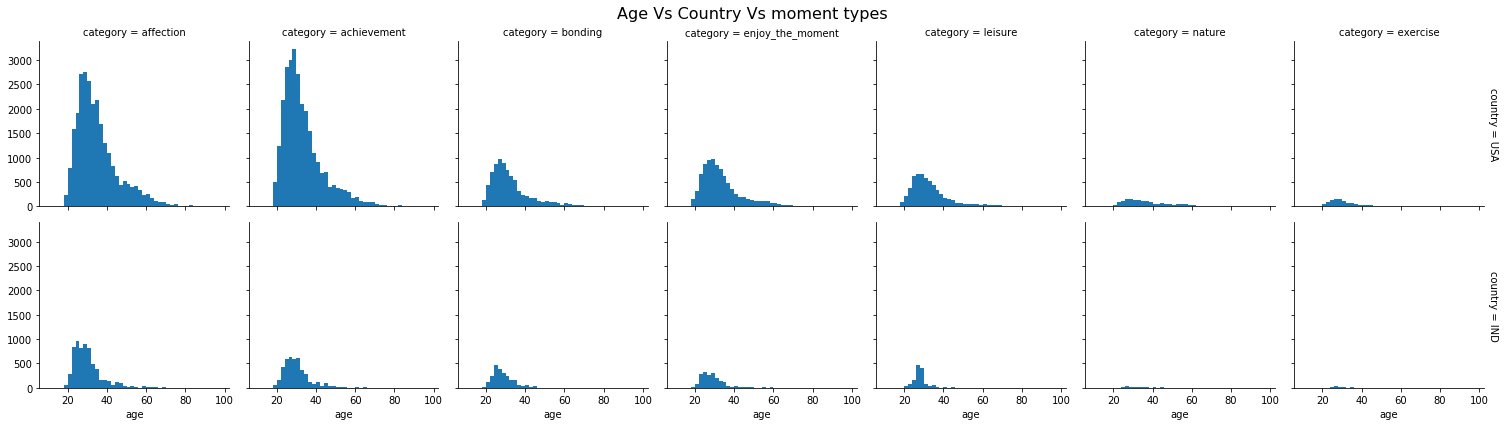

In [308]:
bin_edges = np.arange(10, happy_df2['age'].max()+1, 2)
g = sb.FacetGrid(data = happy_df2, row='country', col = 'category', size = 3, margin_titles=True)
g.map(plt.hist, "age", bins=bin_edges);
plt.subplots_adjust(top=0.9);
# plt.subplots_adjust(hspace=0.5, wspace=0.4)
g.fig.suptitle('Age Vs Country Vs moment types', fontsize=16);

### Gender Vs Country Vs Moments types:

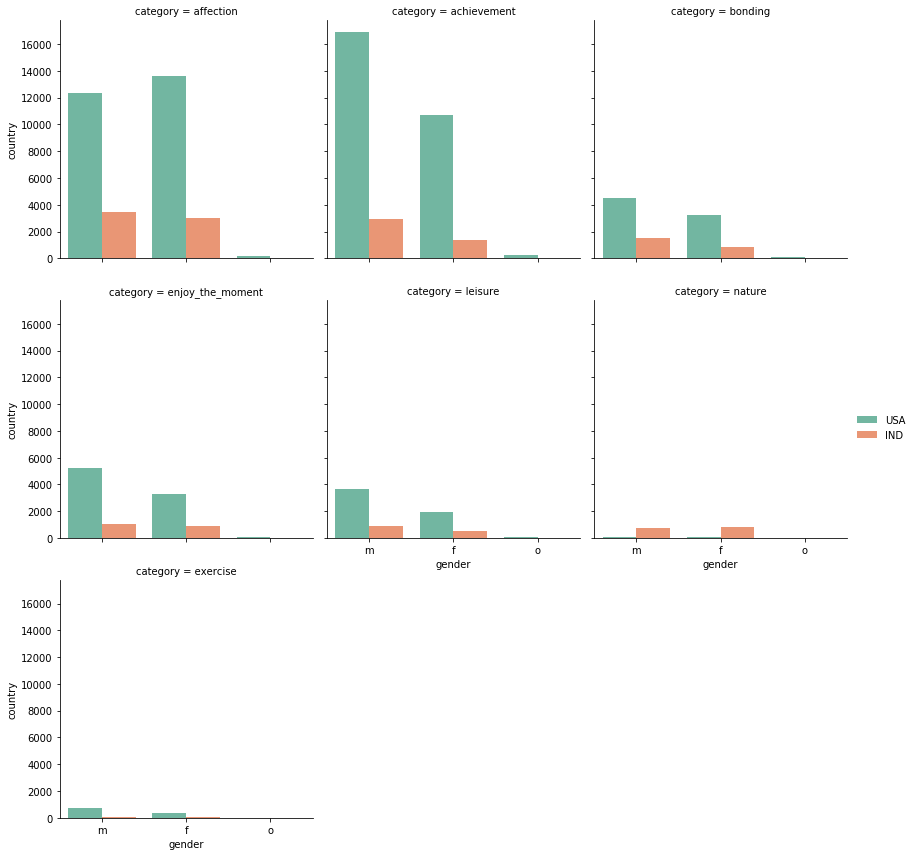

In [325]:
def countplot(x, hue, **kwargs):
    sb.countplot(x=x, hue=hue, **kwargs)

grid = sb.FacetGrid(data=happy_df2, col='category', size=4, col_wrap = 3);
fig = grid.map(countplot,'gender','country',palette='Set2', order=happy_df2.gender.unique());
fig.add_legend();


### Reflection period Vs Marital Vs Moments types:

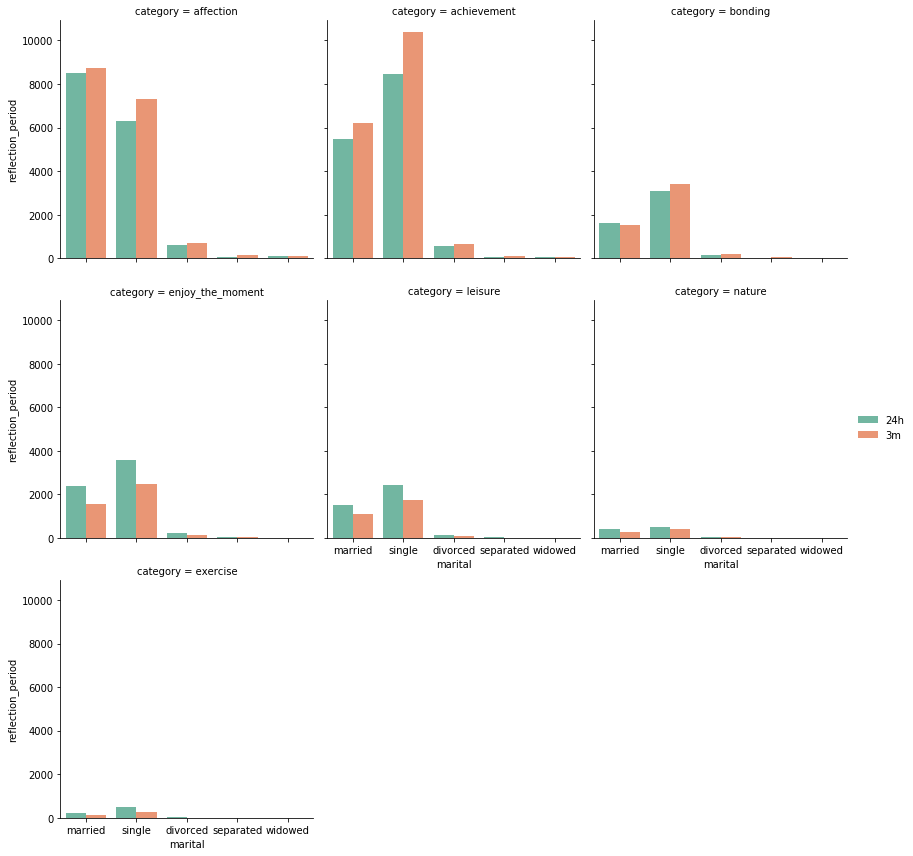

In [319]:
def countplot(x, hue, **kwargs):
    sb.countplot(x=x, hue=hue, **kwargs)

grid = sb.FacetGrid(data=happy_df2, col='category', size=4, col_wrap=3);
fig = grid.map(countplot,'marital','reflection_period',palette='Set2', order=happy_df2.marital.unique());
fig.add_legend();

### Reflection period Vs Parenthood Vs Moments types:

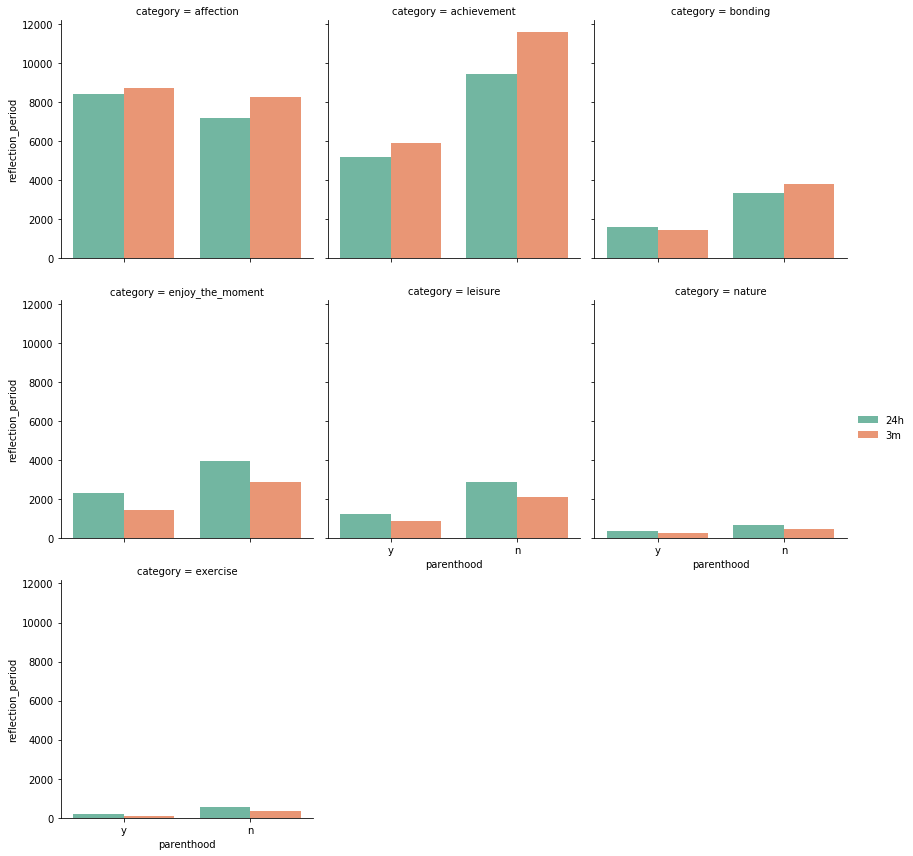

In [326]:
def countplot(x, hue, **kwargs):
    sb.countplot(x=x, hue=hue, **kwargs)

grid = sb.FacetGrid(data=happy_df2, col='category', size=4, col_wrap=3);
fig = grid.map(countplot,'parenthood','reflection_period',palette='Set2', order=happy_df2.parenthood.unique());
fig.add_legend();

> - Reflection period doesn't have clear insight for types of happy moments.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> All observations in this part are confirmed by the previous bivariate exploration section.

### Were there any interesting or surprising interactions between features?

> However multivariate exploration gives deep insights, reflection_period doesn't have clear insight for types of happy moments.

In [327]:
happy_df2.to_csv('cleaned_happy_dataset_v2.csv', sep=',', encoding='utf-8')

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!